In [2]:
# !pip install arch

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import wrds
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Setting up WRDS Access

**WRDS (Wharton Research Data Services)** provides access to financial and economic data.

### First-Time Setup

If you haven't set up your WRDS credentials yet, run the following in a terminal:

```bash
python
>>> import wrds
>>> db = wrds.Connection()
```

You'll be prompted to enter:
- Your WRDS username
- Your WRDS password  

The credentials will be saved for future use.

### For This Notebook

We'll connect to WRDS and download S&P 500 daily data from CRSP (Center for Research in Security Prices).

In [ ]:
# Connect to WRDS
db = wrds.Connection(wrds_username=None)  # Uses saved credentials

# Download S&P 500 data from Compustat
# Use the S&P 500 index from comp.idxcst_his (index constituents historical)
# Or use comp.idx_daily for daily index values
query = """
SELECT datadate as date, prccd as price
FROM comp.idx_daily
WHERE gvkeyx = '000003'
  AND datadate >= '2019-01-01' 
  AND datadate <= '2024-12-31'
ORDER BY datadate
"""

print("Downloading S&P 500 data from WRDS/Compustat...")
data = db.raw_sql(query)

# Close connection
db.close()

# Set date as index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# Calculate log returns
returns = 100 * np.log(data['price'] / data['price'].shift(1))
returns = returns.dropna()

print(f"Data shape: {returns.shape}")
print(f"\nFirst few returns:")
print(returns.head())
print(f"\nBasic statistics:")
print(returns.describe())

Loading library list...
Done
Data shape: (1509,)

First few returns:
date
2019-01-03   -2.506828
2019-01-04    3.375938
2019-01-07    0.698598
2019-01-08     0.96486
2019-01-09    0.408965
Name: price, dtype: Float64

Basic statistics:
count       1509.0
mean      0.056431
std       1.273436
min     -12.765214
25%      -0.460608
50%         0.0916
75%       0.692558
max       8.968316
Name: price, dtype: Float64


### Visualize Returns

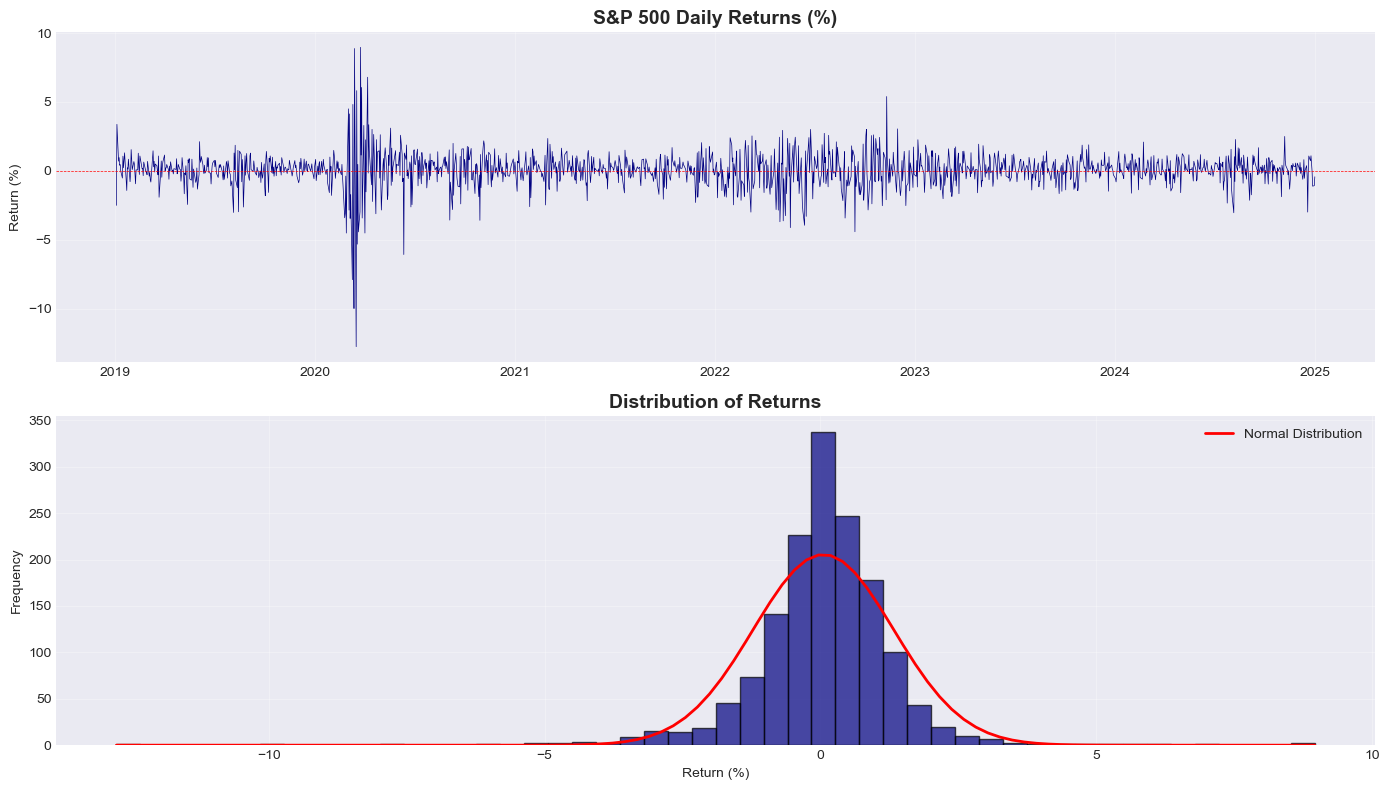

Mean return: 0.0564%
Volatility (std): 1.2734%
Skewness: -0.8535
Kurtosis: 15.2681

Note: Kurtosis > 3 indicates fat tails (leptokurtic distribution)


In [4]:
# Plot returns
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series plot
axes[0].plot(returns.index, returns.values, linewidth=0.5, color='navy')
axes[0].set_title('S&P 500 Daily Returns (%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(returns.values, bins=50, alpha=0.7, color='navy', edgecolor='black')
axes[1].set_title('Distribution of Returns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Add normal distribution overlay
mu, std = returns.mean(), returns.std()
x = np.linspace(returns.min(), returns.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, std) * len(returns) * (returns.max() - returns.min()) / 50, 
             'r-', linewidth=2, label='Normal Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print key statistics
print(f"Mean return: {returns.mean():.4f}%")
print(f"Volatility (std): {returns.std():.4f}%")
print(f"Skewness: {returns.skew():.4f}")
print(f"Kurtosis: {returns.kurtosis():.4f}")
print(f"\nNote: Kurtosis > 3 indicates fat tails (leptokurtic distribution)")

## Part 1: Exponentially Weighted Moving Average (EWMA)

EWMA is a simple but effective method for forecasting volatility.

Formula: $\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) r_{t-1}^2$

RiskMetrics recommends $\lambda = 0.94$ for daily data.

In [5]:
def calculate_ewma(returns, lambda_param=0.94):
    """
    Calculate EWMA volatility.
    
    Parameters:
    -----------
    returns : array-like
        Return series
    lambda_param : float
        Decay factor (default 0.94)
    
    Returns:
    --------
    variance : array
        EWMA variance estimates
    """
    n = len(returns)
    variance = np.zeros(n)
    
    # Initialize with unconditional variance
    variance[0] = returns.var()
    
    # Iterate through returns
    for t in range(1, n):
        variance[t] = lambda_param * variance[t-1] + (1 - lambda_param) * returns.iloc[t-1]**2
    
    return variance

# Calculate EWMA volatility
ewma_var = calculate_ewma(returns, lambda_param=0.94)
ewma_vol = np.sqrt(ewma_var)

# Create DataFrame for easier plotting
vol_df = pd.DataFrame({
    'returns': returns.values,
    'ewma_volatility': ewma_vol
}, index=returns.index)

print("EWMA Volatility calculated successfully!")
print(f"\nMean EWMA volatility: {ewma_vol.mean():.4f}%")
print(f"Max EWMA volatility: {ewma_vol.max():.4f}%")
print(f"Min EWMA volatility: {ewma_vol.min():.4f}%")

EWMA Volatility calculated successfully!

Mean EWMA volatility: 1.0847%
Max EWMA volatility: 5.3436%
Min EWMA volatility: 0.4608%


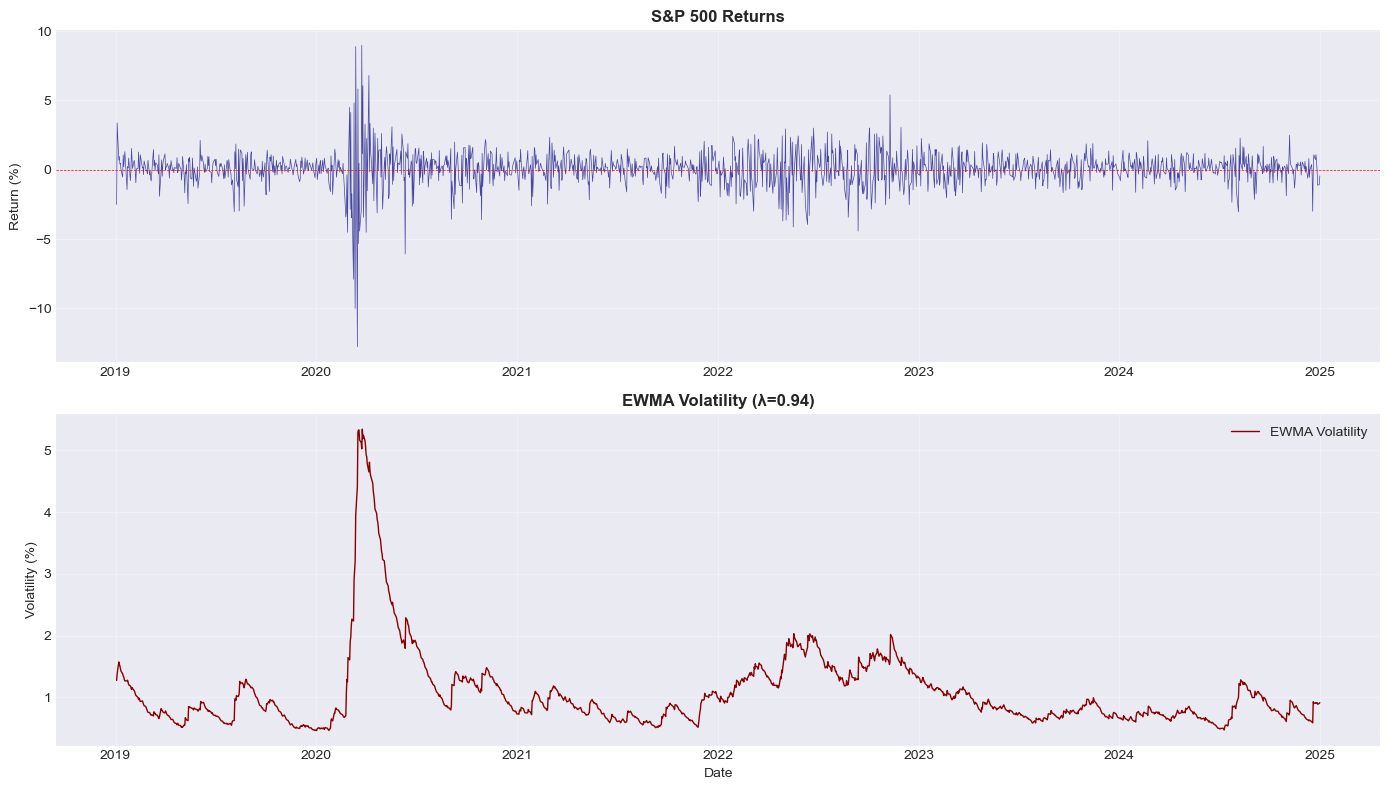


Observation: Notice how volatility clusters - high volatility periods persist!


In [6]:
# Plot EWMA volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns
axes[0].plot(vol_df.index, vol_df['returns'], linewidth=0.5, color='navy', alpha=0.7)
axes[0].set_title('S&P 500 Returns', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

# EWMA Volatility
axes[1].plot(vol_df.index, vol_df['ewma_volatility'], linewidth=1, color='darkred', label='EWMA Volatility')
axes[1].set_title('EWMA Volatility (λ=0.94)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: Notice how volatility clusters - high volatility periods persist!")

## Part 2: GARCH(1,1) Model

GARCH allows the data to determine optimal weights.

Formula: $\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$

We'll use the `arch` package for estimation.

In [7]:
# Fit GARCH(1,1) model
model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
garch_fit = model.fit(disp='off')

# Display results
print(garch_fit.summary())

# Extract parameters
omega = garch_fit.params['omega']
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']

print(f"\n{'='*60}")
print("GARCH(1,1) Parameters:")
print(f"{'='*60}")
print(f"ω (omega): {omega:.6f}")
print(f"α (alpha): {alpha:.6f}")
print(f"β (beta):  {beta:.6f}")
print(f"\nPersistence (α + β): {alpha + beta:.6f}")
print(f"Long-run variance: {omega / (1 - alpha - beta):.6f}")
print(f"Long-run volatility: {np.sqrt(omega / (1 - alpha - beta)):.6f}%")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2108.86
Distribution:                  Normal   AIC:                           4225.72
Method:            Maximum Likelihood   BIC:                           4247.00
                                        No. Observations:                 1509
Date:                Wed, Jan 21 2026   Df Residuals:                     1508
Time:                        11:45:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0944  2.156e-02      4.379  1.190e-05 [5.216e-0

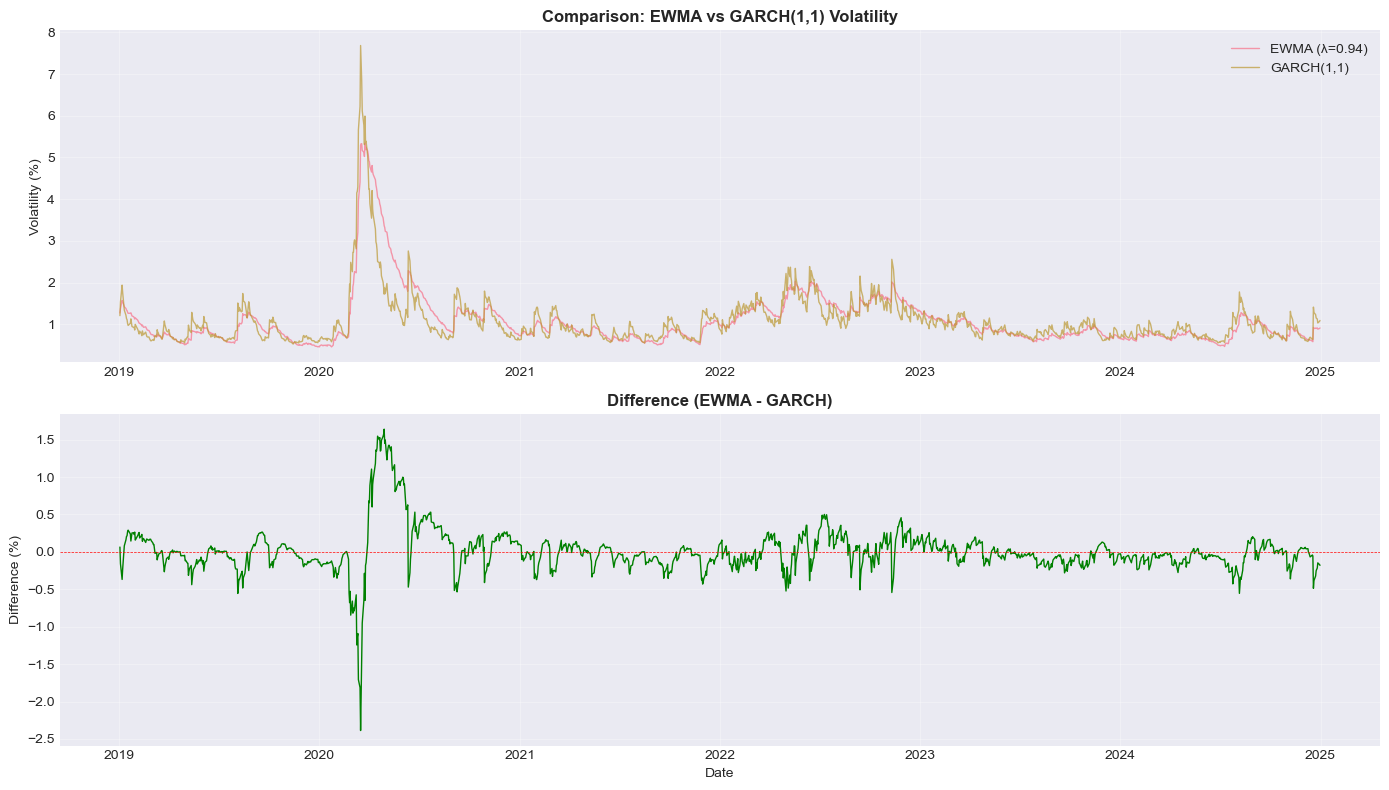

Correlation between EWMA and GARCH: 0.8969


In [8]:
# Extract conditional volatility from GARCH model
garch_vol = garch_fit.conditional_volatility

# Compare EWMA and GARCH
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot both volatility estimates
axes[0].plot(returns.index, ewma_vol, linewidth=1, label='EWMA (λ=0.94)', alpha=0.7)
axes[0].plot(garch_vol.index, garch_vol.values, linewidth=1, label='GARCH(1,1)', alpha=0.7)
axes[0].set_title('Comparison: EWMA vs GARCH(1,1) Volatility', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Volatility (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot difference
diff = ewma_vol - garch_vol.values
axes[1].plot(returns.index, diff, linewidth=1, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=0.5)
axes[1].set_title('Difference (EWMA - GARCH)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Difference (%)')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(ewma_vol, garch_vol.values)[0, 1]
print(f"Correlation between EWMA and GARCH: {correlation:.4f}")

## Part 4: GJR-GARCH Model - Capturing Leverage Effects

The GJR-GARCH model (Glosten, Jagannathan, Runkle, 1993) extends GARCH(1,1) to capture asymmetric volatility responses.

### Model Specification

$$h_t = \omega + \alpha\varepsilon_{t-1}^2 + \gamma\varepsilon_{t-1}^2\mathbb{I}_{\varepsilon_{t-1}<0} + \beta h_{t-1}$$

where $\mathbb{I}_{\varepsilon_{t-1}<0}$ is an indicator function:
- $\gamma > 0$: Negative shocks increase volatility more than positive shocks
- Impact of positive shock: $\alpha$
- Impact of negative shock: $\alpha + \gamma$

### Estimating GJR-GARCH with Python

In [15]:
# Estimate GJR-GARCH(1,1) model
gjr_model = arch_model(returns, vol='GARCH', p=1, o=1, q=1, dist='normal')
gjr_fit = gjr_model.fit(disp='off')

print("GJR-GARCH(1,1) Results:")
print("="*60)
print(gjr_fit.summary())

# Extract parameters
omega_gjr = gjr_fit.params['omega']
alpha_gjr = gjr_fit.params['alpha[1]']
gamma_gjr = gjr_fit.params['gamma[1]']
beta_gjr = gjr_fit.params['beta[1]']

print(f"\n{'='*60}")
print("GJR-GARCH Parameters:")
print(f"{'='*60}")
print(f"ω (omega): {omega_gjr:.6f}")
print(f"α (alpha): {alpha_gjr:.6f} - impact of positive shocks")
print(f"γ (gamma): {gamma_gjr:.6f} - additional impact of negative shocks")
print(f"β (beta):  {beta_gjr:.6f} - persistence")
print(f"\nTotal impact of negative shock: {alpha_gjr + gamma_gjr:.6f}")
print(f"Asymmetry ratio: {(alpha_gjr + gamma_gjr) / alpha_gjr:.3f}")

if gamma_gjr > 0:
    print(f"\n✓ Leverage effect confirmed: γ > 0")
    print(f"  Negative shocks increase volatility {((alpha_gjr + gamma_gjr) / alpha_gjr - 1) * 100:.1f}% more")

GJR-GARCH(1,1) Results:
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2094.83
Distribution:                  Normal   AIC:                           4199.67
Method:            Maximum Likelihood   BIC:                           4226.26
                                        No. Observations:                 1509
Date:                Wed, Jan 21 2026   Df Residuals:                     1508
Time:                        11:47:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0615  2.090e-02      2.

## Part 5: Forecast Comparison and Evaluation

### Hansen & Lunde (2005, 2011): Model Comparison

**Key Findings:**
- Hansen & Lunde (2005): Compared 330 ARCH models on FX data
- Result: Hard to beat GARCH(1,1) for exchange rates
- Hansen et al. (2011): Model Confidence Set (MCS) for rigorous comparison

**Let's compare our models:**

In [16]:
# Compare GARCH vs GJR-GARCH
import pandas as pd

# Extract conditional volatilities
garch_vol_series = garch_fit.conditional_volatility
gjr_vol_series = gjr_fit.conditional_volatility

# Model comparison table
comparison_df = pd.DataFrame({
    'Model': ['GARCH(1,1)', 'GJR-GARCH(1,1)'],
    'Log-Likelihood': [garch_fit.loglikelihood, gjr_fit.loglikelihood],
    'AIC': [garch_fit.aic, gjr_fit.aic],
    'BIC': [garch_fit.bic, gjr_fit.bic],
    'Parameters': [garch_fit.num_params, gjr_fit.num_params]
})

print("\nModel Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))
print("\nNote: Lower AIC/BIC indicates better fit")

# Determine best model
if gjr_fit.aic < garch_fit.aic:
    print(f"\n✓ GJR-GARCH preferred (AIC: {gjr_fit.aic:.2f} vs {garch_fit.aic:.2f})")
else:
    print(f"\n✓ GARCH(1,1) preferred (AIC: {garch_fit.aic:.2f} vs {gjr_fit.aic:.2f})")


Model Comparison:
         Model  Log-Likelihood         AIC         BIC  Parameters
    GARCH(1,1)    -2108.859431 4225.718863 4246.995673           4
GJR-GARCH(1,1)    -2094.832596 4199.665191 4226.261204           5

Note: Lower AIC/BIC indicates better fit

✓ GJR-GARCH preferred (AIC: 4199.67 vs 4225.72)


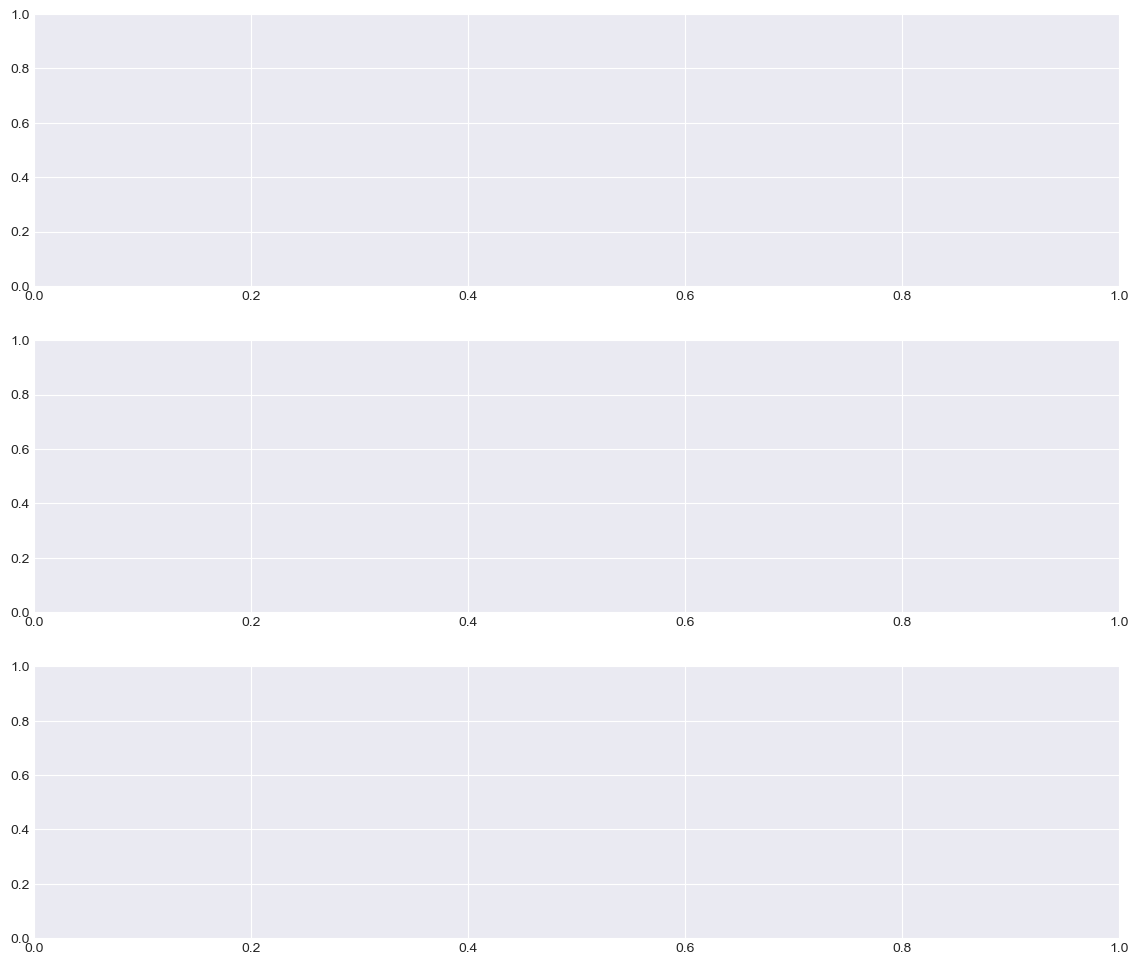

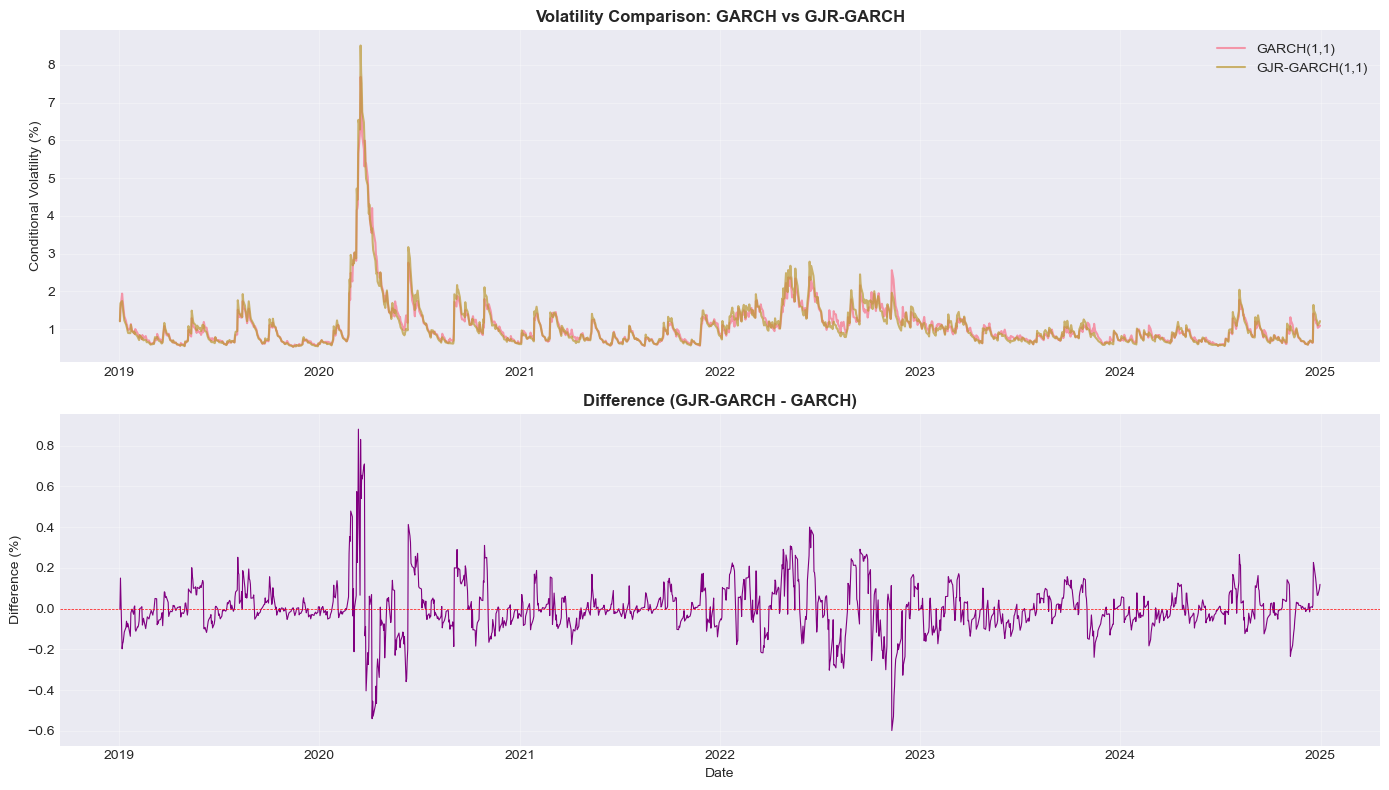


Correlation between models: 0.9852
Mean absolute difference: 0.0815%


In [17]:
# Visual comparison of volatility estimates
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot both volatility series
axes[0].plot(garch_vol_series.index, garch_vol_series, label='GARCH(1,1)', alpha=0.7)
axes[0].plot(gjr_vol_series.index, gjr_vol_series, label='GJR-GARCH(1,1)', alpha=0.7)
axes[0].set_title('Volatility Comparison: GARCH vs GJR-GARCH', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Conditional Volatility (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot difference
diff = gjr_vol_series - garch_vol_series
axes[1].plot(diff.index, diff, color='purple', linewidth=0.8)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=0.5)
axes[1].set_title('Difference (GJR-GARCH - GARCH)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Difference (%)')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between models: {np.corrcoef(garch_vol_series, gjr_vol_series)[0,1]:.4f}")
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}%")

## Part 4: Volatility Forecasting

### One-Step Ahead Forecast
Simply apply the GARCH equation: $\hat{\sigma}_{t+1}^2 = \omega + \alpha r_t^2 + \beta \sigma_t^2$

### Multi-Step Ahead Forecast
Use the formula: $\hat{\sigma}_{t+h}^2 = \sigma_L^2 + (\alpha + \beta)^{h-1}(\hat{\sigma}_{t+1}^2 - \sigma_L^2)$

In [10]:
def forecast_volatility_garch(omega, alpha, beta, current_vol, current_return, horizon=10):
    """
    Generate multi-step ahead GARCH volatility forecasts.
    
    Parameters:
    -----------
    omega, alpha, beta : float
        GARCH parameters
    current_vol : float
        Current volatility estimate
    current_return : float
        Current return
    horizon : int
        Forecast horizon (number of periods ahead)
    
    Returns:
    --------
    forecasts : array
        Volatility forecasts for h=1, 2, ..., horizon
    """
    # Calculate long-run variance
    long_run_var = omega / (1 - alpha - beta)
    
    # One-step ahead forecast
    forecast_1 = np.sqrt(omega + alpha * current_return**2 + beta * current_vol**2)
    
    # Multi-step ahead forecasts
    forecasts = np.zeros(horizon)
    forecasts[0] = forecast_1
    
    persistence = alpha + beta
    
    for h in range(1, horizon):
        var_forecast = long_run_var + persistence**h * (forecast_1**2 - long_run_var)
        forecasts[h] = np.sqrt(var_forecast)
    
    return forecasts

# Generate forecasts from the last date
last_vol = garch_vol.iloc[-1]
last_return = returns.iloc[-1]

forecast_horizon = 20  # 20 days ahead
vol_forecasts = forecast_volatility_garch(omega, alpha, beta, last_vol, last_return, horizon=forecast_horizon)

# Create forecast DataFrame
forecast_dates = pd.bdate_range(start=returns.index[-1], periods=forecast_horizon+1)[1:]
forecast_df = pd.DataFrame({
    'forecast_volatility': vol_forecasts
}, index=forecast_dates)

print("Volatility Forecasts (Next 20 Trading Days)")
print(f"{'='*60}")
print(forecast_df.head(10))
print(f"\nLong-run volatility: {np.sqrt(omega / (1 - alpha - beta)):.4f}%")
print(f"\nDay 1 forecast: {vol_forecasts[0]:.4f}%")
print(f"Day 5 forecast: {vol_forecasts[4]:.4f}%")
print(f"Day 20 forecast: {vol_forecasts[19]:.4f}%")

Volatility Forecasts (Next 20 Trading Days)
            forecast_volatility
2025-01-01             1.014228
2025-01-02             1.020742
2025-01-03             1.026998
2025-01-06             1.033008
2025-01-07             1.038783
2025-01-08             1.044333
2025-01-09             1.049669
2025-01-10             1.054799
2025-01-13             1.059734
2025-01-14             1.064481

Long-run volatility: 1.1929%

Day 1 forecast: 1.0142%
Day 5 forecast: 1.0388%
Day 20 forecast: 1.1032%


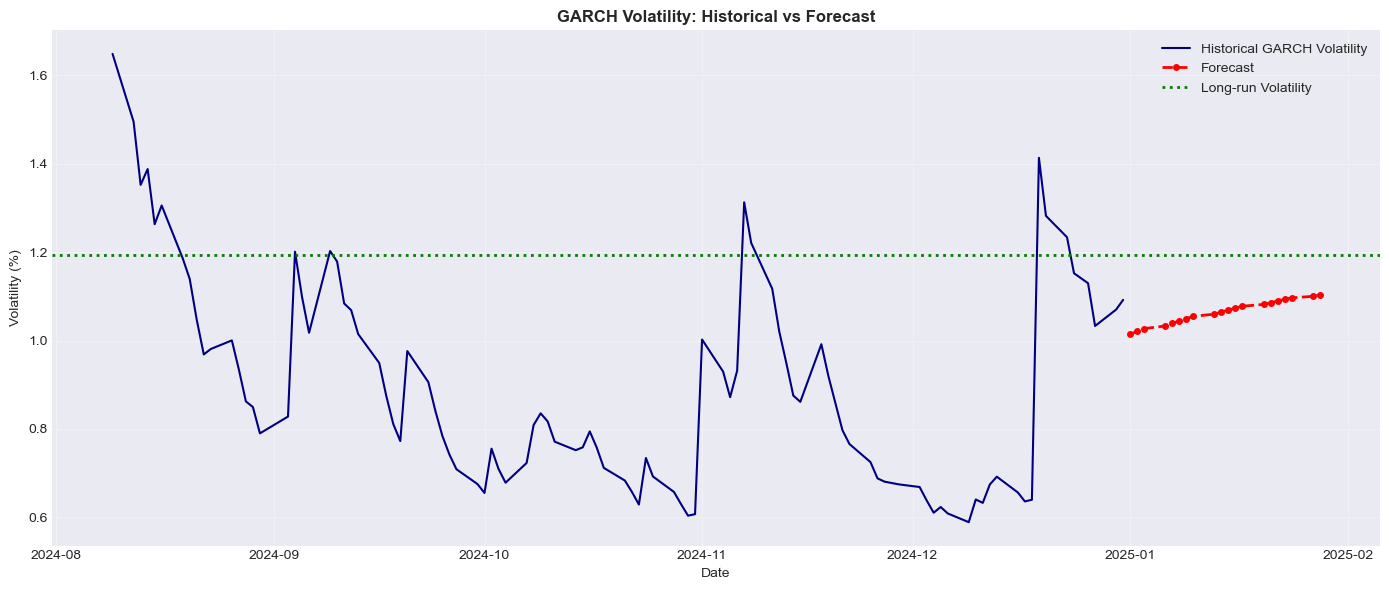


Observation: Forecasts converge to long-run volatility (mean reversion!)


In [11]:
# Plot historical volatility and forecasts
plt.figure(figsize=(14, 6))

# Plot last 100 days of historical volatility
plt.plot(garch_vol.index[-100:], garch_vol.values[-100:], linewidth=1.5, 
         label='Historical GARCH Volatility', color='navy')

# Plot forecasts
plt.plot(forecast_df.index, forecast_df['forecast_volatility'], linewidth=2, 
         label='Forecast', color='red', linestyle='--', marker='o', markersize=4)

# Add long-run volatility
long_run_vol = np.sqrt(omega / (1 - alpha - beta))
plt.axhline(y=long_run_vol, color='green', linestyle=':', linewidth=2, label='Long-run Volatility')

plt.title('GARCH Volatility: Historical vs Forecast', fontsize=12, fontweight='bold')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Forecasts converge to long-run volatility (mean reversion!)")

## Part 5: Trading Strategies Based on Volatility

### Strategy 1: Volatility Targeting

Adjust position size to maintain constant portfolio volatility.

In [12]:
def volatility_targeting_strategy(returns, volatility, target_vol=10.0):
    """
    Implement volatility targeting strategy.
    
    Parameters:
    -----------
    returns : array-like
        Return series
    volatility : array-like
        Volatility forecasts
    target_vol : float
        Target annualized volatility in %
    
    Returns:
    --------
    positions : array
        Position weights
    strategy_returns : array
        Strategy returns
    """
    # Convert daily vol to annual (assuming 252 trading days)
    annual_vol = volatility * np.sqrt(252)
    
    # Calculate position weights (target vol / forecast vol)
    positions = target_vol / annual_vol
    
    # Cap positions at 2x (avoid excessive leverage)
    positions = np.minimum(positions, 2.0)
    
    # Calculate strategy returns (lag positions by 1 day)
    strategy_returns = positions[:-1] * returns.values[1:]
    
    return positions, strategy_returns

# Implement strategy
target_volatility = 10.0  # 10% annual volatility target
positions, strategy_rets = volatility_targeting_strategy(returns, garch_vol, target_vol=target_volatility)

# Calculate cumulative returns
buy_hold_cumret = (1 + returns.values[1:] / 100).cumprod()
strategy_cumret = (1 + strategy_rets / 100).cumprod()

# Create DataFrame for analysis
strategy_df = pd.DataFrame({
    'buy_hold': buy_hold_cumret,
    'vol_targeting': strategy_cumret
}, index=returns.index[1:])

# Calculate performance metrics
def calculate_metrics(returns, annual_factor=252):
    """Calculate performance metrics."""
    total_return = (1 + returns / 100).prod() - 1
    annual_return = (1 + total_return) ** (annual_factor / len(returns)) - 1
    annual_vol = returns.std() * np.sqrt(annual_factor)
    sharpe = annual_return / annual_vol * 100
    max_dd = ((1 + returns / 100).cumprod() / (1 + returns / 100).cumprod().cummax() - 1).min()
    return annual_return, annual_vol, sharpe, max_dd

bh_metrics = calculate_metrics(returns.values[1:])
st_metrics = calculate_metrics(strategy_rets)

print("Performance Comparison: Buy & Hold vs Volatility Targeting")
print(f"{'='*70}")
print(f"{'Metric':<30} {'Buy & Hold':>15} {'Vol Targeting':>15}")
print(f"{'-'*70}")
print(f"{'Annual Return':<30} {bh_metrics[0]:>14.2%} {st_metrics[0]:>14.2%}")
print(f"{'Annual Volatility':<30} {bh_metrics[1]:>14.2f}% {st_metrics[1]:>14.2f}%")
print(f"{'Sharpe Ratio':<30} {bh_metrics[2]:>14.2f} {st_metrics[2]:>14.2f}")
print(f"{'Max Drawdown':<30} {bh_metrics[3]:>14.2%} {st_metrics[3]:>14.2%}")

AttributeError: 'FloatingArray' object has no attribute 'cumprod'

In [ ]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
axes[0].plot(strategy_df.index, strategy_df['buy_hold'], linewidth=1.5, label='Buy & Hold', alpha=0.8)
axes[0].plot(strategy_df.index, strategy_df['vol_targeting'], linewidth=1.5, label='Volatility Targeting', alpha=0.8)
axes[0].set_title('Cumulative Returns: Buy & Hold vs Volatility Targeting', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Position weights over time
axes[1].plot(returns.index[:-1], positions[:-1], linewidth=1, color='darkgreen')
axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='100% Position')
axes[1].set_title('Position Weights (Volatility Targeting)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Position Weight')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Volatility targeting reduces exposure during high volatility periods,")
print("leading to lower overall portfolio volatility and improved risk-adjusted returns!")

### Strategy 2: Volatility Mean Reversion

Trade based on deviations from long-run volatility.

In [13]:
def volatility_mean_reversion_strategy(returns, volatility, lookback=252):
    """
    Implement volatility mean reversion strategy.
    
    Logic:
    - When volatility is above average: reduce exposure (expect mean reversion)
    - When volatility is below average: increase exposure
    
    Parameters:
    -----------
    returns : array-like
        Return series
    volatility : array-like
        Volatility estimates
    lookback : int
        Lookback period for calculating mean volatility
    
    Returns:
    --------
    signals : array
        Trading signals
    strategy_returns : array
        Strategy returns
    """
    # Calculate rolling mean and std of volatility
    vol_series = pd.Series(volatility)
    vol_mean = vol_series.rolling(window=lookback, min_periods=60).mean()
    vol_std = vol_series.rolling(window=lookback, min_periods=60).std()
    
    # Calculate z-score
    vol_zscore = (vol_series - vol_mean) / vol_std
    
    # Generate signals
    # High volatility -> reduce exposure (50% position)
    # Normal volatility -> full exposure (100% position)
    # Low volatility -> increase exposure (150% position, capped)
    signals = np.ones(len(volatility))
    signals[vol_zscore > 1] = 0.5  # High vol
    signals[vol_zscore < -1] = 1.5  # Low vol
    
    # Calculate strategy returns
    strategy_returns = signals[:-1] * returns.values[1:]
    
    return signals, strategy_returns, vol_zscore

# Implement strategy
signals, mean_rev_rets, vol_zscore = volatility_mean_reversion_strategy(returns, garch_vol, lookback=252)

# Calculate cumulative returns
mean_rev_cumret = (1 + mean_rev_rets / 100).cumprod()

# Add to strategy DataFrame
strategy_df['mean_reversion'] = mean_rev_cumret

# Calculate metrics
mr_metrics = calculate_metrics(mean_rev_rets)

print("Performance Comparison: All Strategies")
print(f"{'='*85}")
print(f"{'Metric':<30} {'Buy & Hold':>15} {'Vol Target':>15} {'Mean Reversion':>15}")
print(f"{'-'*85}")
print(f"{'Annual Return':<30} {bh_metrics[0]:>14.2%} {st_metrics[0]:>14.2%} {mr_metrics[0]:>14.2%}")
print(f"{'Annual Volatility':<30} {bh_metrics[1]:>14.2f}% {st_metrics[1]:>14.2f}% {mr_metrics[1]:>14.2f}%")
print(f"{'Sharpe Ratio':<30} {bh_metrics[2]:>14.2f} {st_metrics[2]:>14.2f} {mr_metrics[2]:>14.2f}")
print(f"{'Max Drawdown':<30} {bh_metrics[3]:>14.2%} {st_metrics[3]:>14.2%} {mr_metrics[3]:>14.2%}")

AttributeError: 'FloatingArray' object has no attribute 'cumprod'

In [14]:
# Plot all strategies
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Cumulative returns comparison
axes[0].plot(strategy_df.index, strategy_df['buy_hold'], linewidth=1.5, label='Buy & Hold', alpha=0.8)
axes[0].plot(strategy_df.index, strategy_df['vol_targeting'], linewidth=1.5, label='Volatility Targeting', alpha=0.8)
axes[0].plot(strategy_df.index, strategy_df['mean_reversion'], linewidth=1.5, label='Mean Reversion', alpha=0.8)
axes[0].set_title('Cumulative Returns: All Strategies', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility z-score
axes[1].plot(returns.index, vol_zscore.values, linewidth=1, color='purple')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1, label='High Vol Threshold')
axes[1].axhline(y=-1, color='green', linestyle='--', linewidth=1, label='Low Vol Threshold')
axes[1].fill_between(returns.index, -1, 1, alpha=0.2, color='gray')
axes[1].set_title('Volatility Z-Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Z-Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Trading signals
axes[2].plot(returns.index[:-1], signals[:-1], linewidth=1, color='darkgreen', drawstyle='steps-post')
axes[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5, label='Neutral (100%)')
axes[2].set_title('Position Weights (Mean Reversion Strategy)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Position Weight')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'strategy_df' is not defined

### Direct vs. Iterative Multi-Step Forecasts

**Two approaches for h-step ahead forecasts:**

1. **Iterative (Standard GARCH):**
   - Forecast 1-step ahead, then use it for 2-step, etc.
   - Formula: $\hat{\sigma}_{t+h}^2 = \sigma_L^2 + (\alpha + \beta)^{h-1}(\hat{\sigma}_{t+1}^2 - \sigma_L^2)$
   - Efficient if model correct, but errors compound

2. **Direct Method:**
   - Estimate separate model for each horizon
   - More robust to misspecification
   - No error accumulation

Let's implement both:

In [18]:
# Multi-step forecasts: Iterative method
horizons = [1, 5, 10, 20]  # Days ahead
forecasts_iterative = {}

# Get parameters
omega = garch_fit.params['omega']
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']
sigma_L_sq = omega / (1 - alpha - beta)  # Long-run variance

# Current variance (last observation)
current_var = garch_fit.conditional_volatility.iloc[-1]**2

print("Iterative Multi-Step Forecasts:")
print("="*60)
for h in horizons:
    # Iterative forecast formula
    forecast_var = sigma_L_sq + (alpha + beta)**(h-1) * (current_var - sigma_L_sq)
    forecast_vol = np.sqrt(forecast_var)
    forecasts_iterative[h] = forecast_vol
    print(f"{h}-day ahead forecast: {forecast_vol:.4f}%")

print(f"\nLong-run volatility: {np.sqrt(sigma_L_sq):.4f}%")
print(f"Persistence (α + β): {alpha + beta:.4f}")
print(f"\nNote: Forecasts converge to long-run volatility as horizon increases")

Iterative Multi-Step Forecasts:
1-day ahead forecast: 1.0921%
5-day ahead forecast: 1.1055%
10-day ahead forecast: 1.1197%
20-day ahead forecast: 1.1413%

Long-run volatility: 1.1929%
Persistence (α + β): 0.9664

Note: Forecasts converge to long-run volatility as horizon increases


## Part 6: Advanced - Comparing with Realized Volatility

In practice, we would compare our GARCH forecasts with realized volatility (computed from high-frequency data) or implied volatility from options.

Here, we'll use squared returns as a proxy for realized volatility.

In [19]:
# Load realized volatility from Oxford-Man dataset# This dataset contains 5-minute realized volatility measuresimport zipfile# Extract and load the datawith zipfile.ZipFile('data/oxfordmanrealizedvolatilityindices.zip', 'r') as zip_ref:    with zip_ref.open('oxfordmanrealizedvolatilityindices.csv') as f:        rv_data = pd.read_csv(f, index_col=0, parse_dates=True)# Filter for S&P 500 (.SPX) and select RV5 (5-minute realized volatility)sp500_rv = rv_data[rv_data['Symbol'] == '.SPX'][['rv5']].copy()# Convert to same scale as returns (percentage, annualized daily)# rv5 is in daily variance units, so take sqrt and multiply by 100 for percentagesp500_rv['rv5_pct'] = np.sqrt(sp500_rv['rv5']) * 100# Align with returns datarealized_vol = sp500_rv['rv5_pct'].reindex(returns.index)realized_vol = realized_vol.dropna()# For comparison, also keep the old proxyrealized_vol_proxy_old = np.abs(returns)print(f"Loaded RV5 data:")print(f"  Total observations: {len(sp500_rv)}")print(f"  Date range: {sp500_rv.index.min()} to {sp500_rv.index.max()}")print(f"  Matched with returns: {len(realized_vol)} observations")print(f"\nRV5 statistics:")print(realized_vol.describe())

Forecast Evaluation Metrics
Mean Squared Error (MSE): 0.696931
Root Mean Squared Error (RMSE): 0.834824
Mean Absolute Error (MAE): 0.606079

Mean Forecast Error: -0.245680
Std of Forecast Errors: 0.798120

Correlation (forecast vs realized): 0.5722


In [ ]:
# Calculate forecast errors using RV5 realized volatility
# Align GARCH volatility with realized volatility dates
garch_vol_aligned = garch_vol.reindex(realized_vol.index).dropna()
realized_vol_aligned = realized_vol.reindex(garch_vol_aligned.index)

forecast_errors = realized_vol_aligned.values - garch_vol_aligned.values

# Calculate MSE and MAE
mse = np.mean(forecast_errors**2)
mae = np.mean(np.abs(forecast_errors))
rmse = np.sqrt(mse)

print("Forecast Evaluation Metrics (using RV5 realized volatility)")
print(f"{'='*60}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"\nMean Forecast Error: {forecast_errors.mean():.6f}")
print(f"Std of Forecast Errors: {forecast_errors.std():.6f}")

# Correlation between forecast and realized
correlation = np.corrcoef(garch_vol_aligned.values, realized_vol_aligned.values)[0, 1]
print(f"\nCorrelation (GARCH forecast vs RV5): {correlation:.4f}")

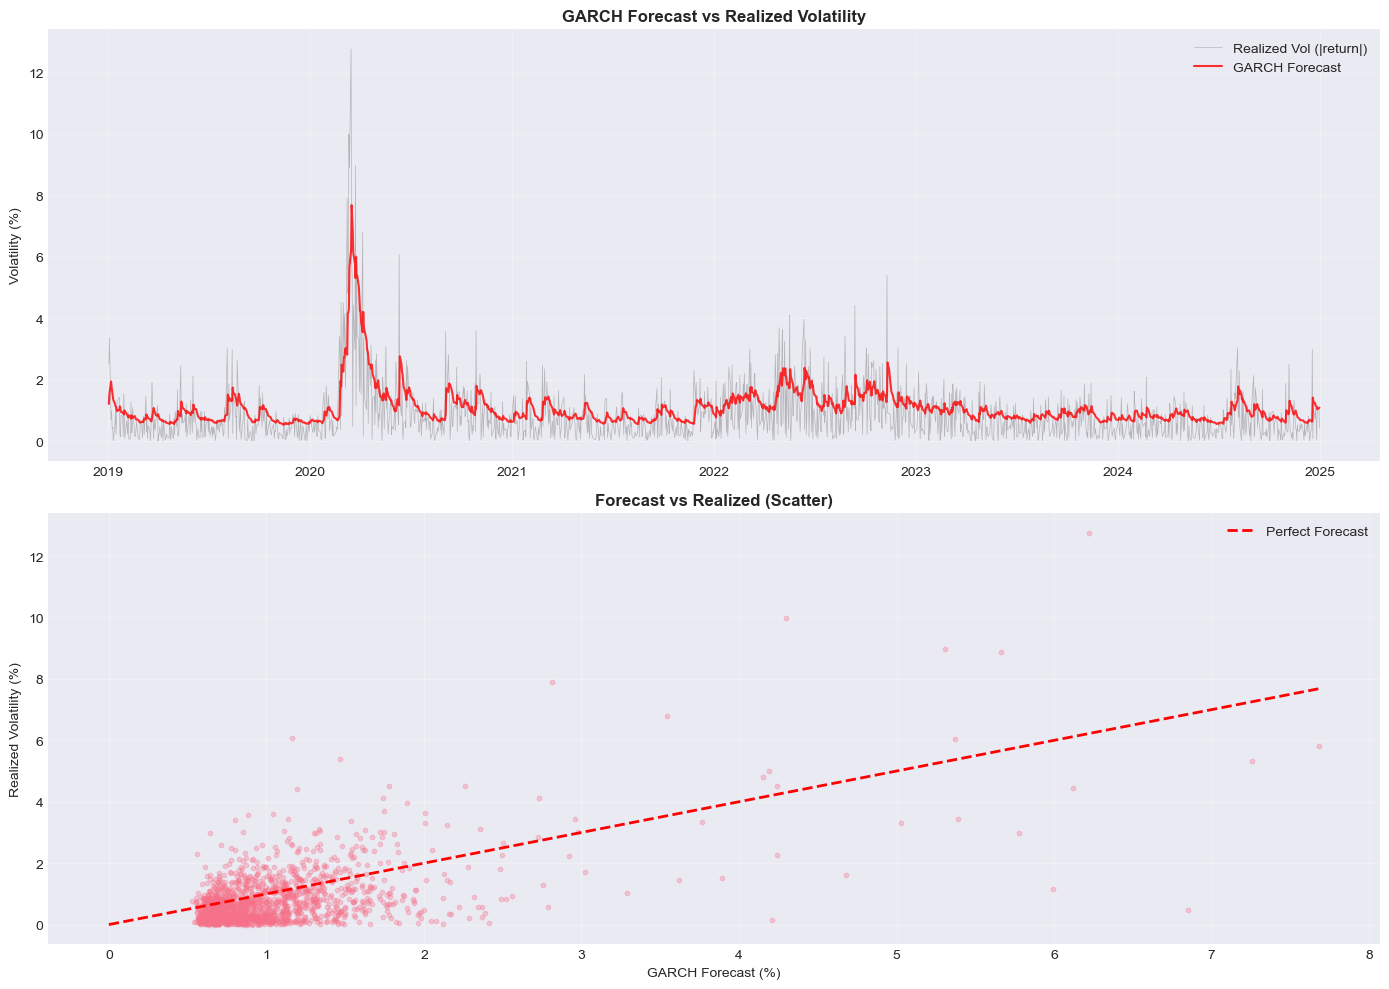

In [20]:
# Plot forecast vs realizedfig, axes = plt.subplots(2, 1, figsize=(14, 10))# Time series comparisonaxes[0].plot(garch_vol_aligned.index, realized_vol_aligned.values, linewidth=0.5, alpha=0.5, label='Realized Vol (|return|)', color='gray')axes[0].plot(garch_vol_aligned.index, garch_vol_aligned.values, linewidth=1.5, label='GARCH Forecast', color='red', alpha=0.8)axes[0].set_title('GARCH Forecast vs Realized Volatility', fontsize=12, fontweight='bold')axes[0].set_ylabel('Volatility (%)')axes[0].legend()axes[0].grid(True, alpha=0.3)# Scatter plotaxes[1].scatter(garch_vol_aligned.values, realized_vol_aligned.values, alpha=0.3, s=10)axes[1].plot([0, garch_vol_aligned.max()], [0, garch_vol_aligned.max()], 'r--', linewidth=2, label='Perfect Forecast')axes[1].set_title('Forecast vs Realized (Scatter)', fontsize=12, fontweight='bold')axes[1].set_xlabel('GARCH Forecast (%)')axes[1].set_ylabel('Realized Volatility (%)')axes[1].legend()axes[1].grid(True, alpha=0.3)plt.tight_layout()plt.show()

## Part 6: Advanced Volatility Models 

### Advanced Volatility Models

The PDF presentation covers several advanced extensions:

#### 1. Asymmetric Models - Leverage Effect

**GJR-GARCH** (Glosten et al., 1993): $h_t = \omega + \alpha\varepsilon_{t-1}^2 + \gamma\varepsilon_{t-1}^2\mathbb{I}_{\varepsilon_{t-1}<0} + \beta h_{t-1}$

**EGARCH** (Nelson, 1991): $\log(h_t) = \omega + \gamma_1 z_{t-1} + \alpha_1(|z_{t-1}| - E[|z_{t-1}|]) + \beta_1\log(h_{t-1})$

**APARCH** (Ding et al., 1993): $h_t^{\delta/2} = \omega + \alpha(|\varepsilon_{t-1}| - \gamma\varepsilon_{t-1})^\delta + \beta h_{t-1}^{\delta/2}$

#### 2. Long Memory - FIGARCH

**FIGARCH** (Baillie et al., 1996) captures hyperbolic decay in volatility ACF

#### 3. Structural Breaks - MRS-GARCH

**Markov-Regime-Switching models** allow parameters to vary across regimes

**See:** `VOLATILITY_MODELING.md` and `volatility_lecture.tex` for full details

## Exercise: Oh & Patton (2024) - Realized Volatility Analysis

**Reference:** Oh & Patton (2024), "Modeling and Forecasting Realized Volatility"

In this exercise, you will:
1. Compare GARCH forecasts with realized volatility (RV5)
2. Estimate a simple HAR-RV model
3. Compare forecasting performance

### Background

The HAR (Heterogeneous Autoregressive) model aggregates realized volatility over multiple horizons:

$$RV_{t+1} = \beta_0 + \beta_D RV_t + \beta_W RV_t^{(w)} + \beta_M RV_t^{(m)} + \varepsilon_t$$

where:
- $RV_t$: Daily realized volatility
- $RV_t^{(w)} = \frac{1}{5}\sum_{i=0}^{4} RV_{t-i}$: Weekly average
- $RV_t^{(m)} = \frac{1}{22}\sum_{i=0}^{21} RV_{t-i}$: Monthly average

In [ ]:
# Exercise: Implement HAR-RV model

# Step 1: Prepare realized volatility features
rv_df = pd.DataFrame({'rv': realized_vol})

# Calculate weekly and monthly averages
rv_df['rv_weekly'] = rv_df['rv'].rolling(window=5, min_periods=5).mean()
rv_df['rv_monthly'] = rv_df['rv'].rolling(window=22, min_periods=22).mean()

# Create lagged features (shift by 1 for forecasting)
rv_df['rv_lag1'] = rv_df['rv'].shift(1)
rv_df['rv_weekly_lag1'] = rv_df['rv_weekly'].shift(1)
rv_df['rv_monthly_lag1'] = rv_df['rv_monthly'].shift(1)

# Drop NaN values
rv_df = rv_df.dropna()

print("HAR-RV Model Data Prepared")
print(f"Sample size: {len(rv_df)}")
print(f"\nFirst few rows:")
print(rv_df.head())

In [ ]:
# Step 2: Estimate HAR-RV model using OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split into train/test (80/20)
train_size = int(0.8 * len(rv_df))
train_df = rv_df.iloc[:train_size]
test_df = rv_df.iloc[train_size:]

# Features and target
X_train = train_df[['rv_lag1', 'rv_weekly_lag1', 'rv_monthly_lag1']]
y_train = train_df['rv']
X_test = test_df[['rv_lag1', 'rv_weekly_lag1', 'rv_monthly_lag1']]
y_test = test_df['rv']

# Estimate HAR model
har_model = LinearRegression()
har_model.fit(X_train, y_train)

# Print coefficients
print("HAR-RV Model Estimation Results")
print(f"{'='*60}")
print(f"Intercept (β₀): {har_model.intercept_:.6f}")
print(f"Daily (βD):     {har_model.coef_[0]:.6f}")
print(f"Weekly (βW):    {har_model.coef_[1]:.6f}")
print(f"Monthly (βM):   {har_model.coef_[2]:.6f}")

# In-sample fit
y_train_pred = har_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"\nIn-sample R²: {r2_train:.4f}")

# Out-of-sample forecast
y_test_pred = har_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Out-of-sample R²: {r2_test:.4f}")
print(f"Out-of-sample MSE: {mse_test:.6f}")

In [ ]:
# Step 3: Compare HAR-RV with GARCH forecasts

# Get GARCH forecasts for test period
garch_test = garch_vol_aligned.reindex(test_df.index).dropna()
y_test_common = y_test.reindex(garch_test.index)
har_test_common = pd.Series(y_test_pred, index=test_df.index).reindex(garch_test.index)

# Calculate MSE for both models
mse_garch = mean_squared_error(y_test_common, garch_test)
mse_har = mean_squared_error(y_test_common, har_test_common)

print("\nModel Comparison (Out-of-Sample Forecast Accuracy)")
print(f"{'='*60}")
print(f"{'Model':<20} {'MSE':>15} {'RMSE':>15}")
print(f"{'-'*60}")
print(f"{'GARCH(1,1)':<20} {mse_garch:>15.6f} {np.sqrt(mse_garch):>15.6f}")
print(f"{'HAR-RV':<20} {mse_har:>15.6f} {np.sqrt(mse_har):>15.6f}")
print(f"{'-'*60}")
print(f"\nImprovement: {((mse_garch - mse_har) / mse_garch * 100):.2f}%")

if mse_har < mse_garch:
    print("✓ HAR-RV outperforms GARCH(1,1) for this dataset")
else:
    print("✓ GARCH(1,1) outperforms HAR-RV for this dataset")

In [ ]:
# Step 4: Visualize forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot forecasts vs realized
axes[0].plot(y_test_common.index, y_test_common.values, 
             linewidth=0.8, alpha=0.6, label='Realized RV5', color='black')
axes[0].plot(garch_test.index, garch_test.values, 
             linewidth=1.5, label='GARCH Forecast', alpha=0.8)
axes[0].plot(har_test_common.index, har_test_common.values, 
             linewidth=1.5, label='HAR-RV Forecast', alpha=0.8)
axes[0].set_title('Out-of-Sample Forecasts: GARCH vs HAR-RV', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Volatility (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot forecast errors
garch_errors = y_test_common.values - garch_test.values
har_errors = y_test_common.values - har_test_common.values
axes[1].plot(y_test_common.index, garch_errors, 
             linewidth=1, alpha=0.7, label='GARCH Errors')
axes[1].plot(y_test_common.index, har_errors, 
             linewidth=1, alpha=0.7, label='HAR-RV Errors')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=0.5)
axes[1].set_title('Forecast Errors', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Error (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📚 Key Insight (Oh & Patton, 2024):")
print("HAR models often outperform GARCH for realized volatility forecasting")
print("because they directly use high-frequency information and capture")
print("heterogeneous market participant behavior across multiple horizons.")